## CS-E4740 - Federated Learning D (Spring 25)

# Assignment 5: FL Main Flavors

### A. Pavlyuk, A. Jung, and ChatGPT

<a id='varying_features'></a>
<div class="alert alert-warning">
    <h2>Deadline: 14.04.2025</h2>
</div>

<a id='varying_features'></a><div class="alert alert-info">

## Learning Goals
After completing the notebook, you should
    
- understand when and how to use vertical federated learning (FL),
- understand when and how to use clustered FL.


## Background Material

1. Chapter 6 of [FLBook](https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FLBook.pdf)

## Notebook Structure
1. The notebook consists of two parts: coding tasks (referred to as Task) and quiz questions (referred as Question). 
2. Both Tasks and Questions use a point-separated index X.Y, where X is the number of the notebook and Y is the number of the task/question in the X'th notebook.

## Importing necessary libraries

In [1]:
# General
import copy # Provides shallow and deep copy operations for objects
import numpy as np # NumPy for numerical computations and array manipulations
import pandas as pd # Pandas for data manipulation and analysis
from datetime import datetime # Handles date and time operations
from numpy import linalg as LA # Linear algebra functions
import matplotlib.pyplot as plt # Matplotlib for data visualization

# Scikit-learn methods
from sklearn.cluster import KMeans # K-Means clustering algorithm for partitioning data into clusters
from sklearn.mixture import GaussianMixture # Gaussian Mixture Model (GMM) for probabilistic clustering
from sklearn.neighbors import kneighbors_graph # Computes the k-nearest neighbor graph
from sklearn.metrics import mean_squared_error # Measures the mean squared error for regression tasks

# We will use NetworkX objects to store empirical graphs, local datasets, and models.
import networkx as nx # NetworkX helps in creating, manipulating, and analyzing graph structures

## Helper functions

In [2]:
def plotFMI(G, save_path=None):
    """
    Generates a scatter plot of FMI stations, coloring nodes based on clusters 
    and edges with a gradient effect using the nearest node's cluster color.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node represents an FMI station, 
        containing:
        - 'coord' (tuple: latitude, longitude) for spatial positioning.
        - 'cluster' (int) for cluster assignment.

    save_path : str, optional
        If provided, saves the plot to the specified file path.

    Returns
    -------
    None
        Displays a scatter plot of stations, where:
        - Nodes are plotted based on their geographic coordinates.
        - Nodes are colored according to their cluster.
        - Node labels correspond to their index in the coordinate array.
        - Edges are split at the midpoint and colored based on adjacent node clusters.
    """
    # Define colors for clusters
    colors = np.array(['black', 'green', 'red', 'brown', 'deeppink',
                        'blue', 'olive', 'gray', 'orange', 'purple'])

    # Extract coordinates and clusters
    coords = np.array([G.nodes[node]['coord'] for node in G.nodes])
    clusters = np.array([G.nodes[node]['cluster'] for node in G.nodes])

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Draw nodes, colored by cluster
    ax.scatter(coords[:, 1], coords[:, 0], c=colors[clusters], s=50, zorder=5)

    # Add labels
    for node, (lat, lon) in enumerate(coords):
        ax.text(lon + 0.1, lat + 0.2, str(node), fontsize=8, ha='center', va='center', color=colors[clusters[node]], fontweight='bold')

    # Draw edges, with half colored by the nearest node's cluster
    for u, v in G.edges:
        u_color = colors[G.nodes[u]['cluster']]
        v_color = colors[G.nodes[v]['cluster']]
        u_coords = G.nodes[u]['coord']
        v_coords = G.nodes[v]['coord']

        # Plot half edges
        mid_point = [(u_coords[0] + v_coords[0]) / 2, (u_coords[1] + v_coords[1]) / 2]
        ax.plot([u_coords[1], mid_point[1]], [u_coords[0], mid_point[0]], linestyle='-', color=u_color, zorder=3)
        ax.plot([mid_point[1], v_coords[1]], [mid_point[0], v_coords[0]], linestyle='-', color=v_color, zorder=3)

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('FMI Stations Colored by Cluster')
    
    # Adjust according to Tissot's indicatrix
    ax.set_aspect(1.6)
    
    if save_path != None:
        try:
            plt.savefig(save_path)
        except: 
            print("Failed to save the plot. Invalid file path.")
            
    plt.show()


def add_edges(G, z='coord', numneighbors=4):
    """Adds edges to a graph based on k-nearest neighbors using the representation vector.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node has a 'coord' attribute with (latitude, longitude).
    numneighbors : int, optional
        Number of nearest neighbors to connect to each node, by default 4.
    z : string, optional
        The name of the attribute to use as the representation vector, by default 'coord'.

    Returns
    -------
    networkx.Graph
        A new graph with added edges based on k-nearest neighbors.
    """
    # Deep copy the graph to avoid modifying the original
    graph_with_edges = copy.deepcopy(G)

    # Extract the representation vector
    if z == 'Timestamp':
        representation_vector = np.array([graph_with_edges.nodes[node][z].timestamp() for node in graph_with_edges.nodes]).reshape(-1, 1)
    else:
        representation_vector = np.array([graph_with_edges.nodes[node][z] for node in graph_with_edges.nodes])

    # Create adjacency matrix using k-nearest neighbors
    adjacency_matrix = kneighbors_graph(representation_vector, 
                                        numneighbors, 
                                        mode='connectivity', 
                                        include_self=False)

    # Add edges based on the adjacency matrix
    edges = zip(*adjacency_matrix.nonzero())
    graph_with_edges.add_edges_from(edges)

    return graph_with_edges

def ExtractFeatureMatrixLabelVector(data):
    """Extracts feature matrix and label vector from FMI weather data.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing columns "Latitude", "Longitude", "temp", "Timestamp".
    
    Returns
    -------
    X : numpy.ndarray
        Feature matrix where each row corresponds to a data point.
    y : numpy.ndarray
        Label vector containing temperature values for each data point.
    """
    # Extract temperature values and normalize latitude/longitude.
    temps = data['temp'].values
    latitudes = data['Latitude'].values / 100
    longitudes = data['Longitude'].values / 100

    # Extract and normalize time-based features (year, month, day, hour, minute).
    timestamps = pd.to_datetime(data['Timestamp'])
    year = timestamps.dt.year / 2025
    month = timestamps.dt.month / 13
    day = timestamps.dt.day / 32
    hour = timestamps.dt.hour / 25
    minute = timestamps.dt.minute / 61

    # Combine features into the feature matrix
    X = np.column_stack([latitudes, longitudes, year, month, day, hour, minute])
    y = temps.reshape(-1, 1)

    return X, y

## Get Data

In [3]:
# Import the weather measurements
data = pd.read_csv('FMI_data.csv')

# In this notebook we need an equally-sized local dataset.
# This is particularly necessary for vertical FL.
# Therefore, we remove all stations with incomplete data.

# Identify stations with fewer than 96 entries
stations_to_remove = data.groupby('name').filter(lambda x: len(x) < 96)['name'].unique()

# Remove rows for these stations
data = data[~data['name'].isin(stations_to_remove)]

# Convert 'Timestamp' column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.

# Get the number of data points and the number of unique stations.
n_stations = len(data.name.unique())
n_datapoints = len(data)

## Building an FMI Network

The empirical graph is connected: True


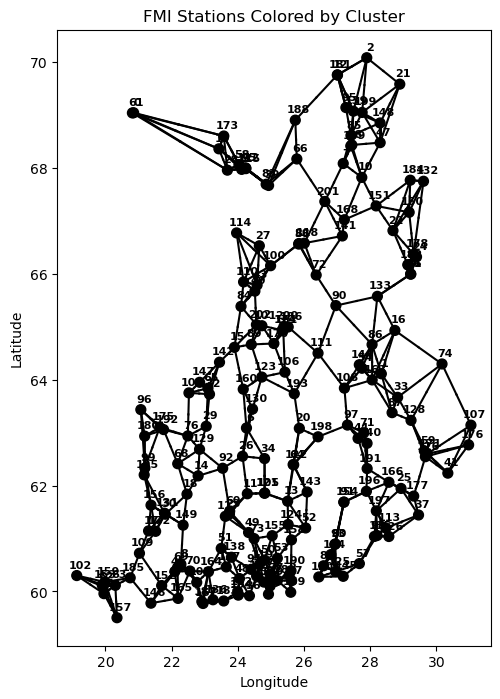

In [4]:
# In what follows, we:
# 1. construct the empirical graph G_FMI as a networkx.Graph() object,
# 2. add a single node for each station,
# 3. for each node add the following attributes: 
#   'samplesize' - The number of measurements of the i-th weather station,
#   'name' - the name of the i-th weather station,
#   'coord' - the coordinates of the i-th weather station,
#   'X', 'y' - the data,
#   'cluster' - the cluster to which the node is assigned.

# Create a networkX graph
G_FMI_no_edges = nx.Graph()

# Add one node per station
G_FMI_no_edges.add_nodes_from(range(0, n_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of the given station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X_node, y_node = ExtractFeatureMatrixLabelVector(station_data)
    
    # Assign node attributes
    G_FMI_no_edges.nodes[i].update({
        'samplesize': len(y_node), # Number of measurements of the i-th weather station
        'name': station, # Name of the i-th weather station
        'coord': (station_data.Latitude.iloc[0], station_data.Longitude.iloc[0]), # Coordinates of the i-th weather station
        'X': X_node, # Feature matrix for the local dataset at node i
        'y': y_node, # Label vector for the local dataset at node i
        'cluster': 0 # Cluster assignment (default value = 0)
    })

# Add edges between each station and its nearest neighbors.
# NOTE: The node degree may vary across nodes.
G_FMI = add_edges(G_FMI_no_edges, numneighbors=4)
print("The empirical graph is connected:", nx.is_connected(G_FMI))

# Visualize the empirical graph
plotFMI(G_FMI)

## Vertical FL

__Problem:__ Each party has different features for the same set of entities or users. For example, different hospitals store different types of medical data for the same group of patients.

__Solution:__ Vertical FL uses local datasets that contain the same (identical!) data points. However, each local dataset uses a different choice of features to characterize these data points.   

<center>
<img src="vertical_FL.png" alt="Vertical FL" width="50%"/>
</center>

<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 5.1 - Vertical FL

__Task description:__
1. In contrast to earlier assignments, we now use a global choice for data points: 
    a data point represents the hourly weather conditions across all of Finland.
    The features $\mathbf{x} = (\mathcal{x}^{(1)},...,\mathcal{x^{(n)}})^T$ 
    of a data point are the local temperature measurements $\mathcal{x^{(i)}}$ 
    at FMI stations $\mathcal{i} = 1,...,\mathcal{n}$. The label of this data point
    is the average temperature (across Finland) during the following hour. Store the features
    and labels in `datapoints` (i.e., the $i$-th element of `datapoints` is $(\mathbf{x}^{(i)}, y^{(i)})$).
2. Use the zero-gradient condition (see FLBook, Section 3.4) to compute a solution for the GTVMin instance in matrix form.
    
__IMPORTANT:__
1. Make sure that `datapoints` lists datapoints in the ascending Timestamp order! 
</div>

In [5]:
# Sort data by ascending Timestamp
data = data.sort_values('Timestamp')

In [6]:
### TASK ###
# datapoints = 

### BEGIN SOLUTION
# Group the data by 'Timestamp' and convert temperatures to NumPy arrays
X = data.groupby('Timestamp')['temp'].apply(np.array).to_numpy()[:-1]

# Group the data by 'Timestamp' and calculate average temperatures
y = data.groupby('Timestamp')['temp'].mean().to_numpy()[1:]

# Construct datapoints
datapoints = np.array([(X[i], y[i]) for i in range(len(y))], dtype='object')
### END SOLUTION

In [7]:
# Sanity checks

# Check if the shape of datapoints list is correct
assert np.shape(datapoints) == (95, 2), "The shape of the datapoints list is incorrect."
assert np.all([np.shape(datapoints[i][0]) == (203,) for i in range(len(datapoints))]), "Each datapoint should have 203 features."

print('Sanity check passed!')

Sanity check passed!


In [8]:
# Get all unique Timestamps
timestamps = data['Timestamp'].unique()

# Create a networkX graph
G_FMI_vertical = nx.Graph()

# Add one node per hourly measurement
G_FMI_vertical.add_nodes_from(range(0, len(datapoints)))

for node in G_FMI_vertical.nodes:
    # Assign node attributes
    G_FMI_vertical.nodes[node].update({
        'Timestamp': timestamps[node],
        'X': datapoints[node][0], # Feature matrix for the local dataset
        'y': datapoints[node][1], # Label vector for the local dataset 
    })

# Add edges
G_FMI_vertical = add_edges(G_FMI_vertical, z='Timestamp', numneighbors=4)

# Define the regularization parameter
gtvmin_alpha = 0.9

In [9]:
from scipy.sparse import block_diag
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Q = 
# q = 
# L_FMI = 
# hat_w = 

### BEGIN SOLUTION
# Initialize Q and q
Q_list = []
q_list = []

# Loop to calculate both Q and q in one go
for i in range(len(datapoints)):
    X_i = datapoints[i][0].reshape(1, -1)
    y_i = datapoints[i][1].reshape(-1, 1)
    m_i = len(X_i)

    # Calculate Q_i
    Q_i = (1 / m_i) * np.dot(X_i.T, X_i)
    Q_list.append(Q_i)
    
    # Calculate q_i
    q_i = (-2 / m_i) * np.dot(X_i.T, y_i) # q(i) = (-2/mi) * X(i)^T * y(i)
    q_list.append(q_i)

Q_blockdiag = block_diag(Q_list).tocsc()
q_stacked = np.vstack(q_list)        # shape: (n*d, 1)
print('Q_blockdiag shape:', Q_blockdiag.shape, '\nq_stacked shape:  ', q_stacked.shape)

d = len(X[0])
L_FMI = nx.laplacian_matrix(G_FMI_vertical).toarray()  # shape: (n, n)
I_d = np.eye(d) # shape: d x d
L_kron = csr_matrix(np.kron(L_FMI, I_d))
print('L_kron shape', L_kron.shape)

Q = Q_blockdiag + gtvmin_alpha * L_kron
print('Q shape:', Q.shape)

q = q_stacked.reshape(-1, 1)
print('q shape:', q.shape)

hat_w = spsolve(Q, -0.5*q)
hat_w = hat_w.reshape(-1, d)
# print(hat_w)
print('hat_w', hat_w.shape)
### END SOLUTION

# Toy scenario:
# m = 5 datapoints
# d = 3 features
X_toy = np.ones((5, 3))
y_toy = np.ones((5, 1))*2
datapoints_toy = np.array([(X_toy[i], y_toy[i]) for i in range(len(y_toy))], dtype='object')
#hat_w_toy = 
#assert hat_w_toy == array([[1.10942456, 0.43928868, 0.45128676],
#                           [1.10942456, 0.43928868, 0.45128676],
#                           [1.10942456, 0.43928868, 0.45128676],
#                           [1.10942456, 0.43928868, 0.45128676],
#                           [1.10942456, 0.43928868, 0.45128676]])

Q_blockdiag shape: (19285, 19285) 
q_stacked shape:   (19285, 1)
L_kron shape (19285, 19285)
Q shape: (19285, 19285)
q shape: (19285, 1)
hat_w (95, 203)


In [10]:
# Sanity checks

# Check if the shape of datapoints list is correct
assert hat_w.shape == (95, 203), "The shape of the local models' parameters is wrong."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
#from scipy.sparse import block_diag
#from scipy.sparse import csr_matrix
#from scipy.sparse.linalg import spsolve
#
#test_X = data.groupby('Timestamp')['temp'].apply(np.array).to_numpy()[:-1]
#test_y = data.groupby('Timestamp')['temp'].mean().to_numpy()[1:]
#test_datapoints = np.array([(test_X[i], test_y[i]) for i in range(len(test_y))], dtype='object')
#
#test_timestamps = data['Timestamp'].unique()
#test_G_FMI_vertical = nx.Graph()
#test_G_FMI_vertical.add_nodes_from(range(0, len(test_datapoints)))
#for node in test_G_FMI_vertical.nodes:
#    test_G_FMI_vertical.nodes[node].update({
#        'Timestamp': test_timestamps[node],
#        'X': test_datapoints[node][0], 
#        'y': test_datapoints[node][1], 
#    })
#test_G_FMI_vertical = add_edges(test_G_FMI_vertical, z='Timestamp', numneighbors=4)
#test_gtvmin_alpha = 0.9
#
#test_L_FMI = nx.laplacian_matrix(test_G_FMI_vertical).toarray()
#
## Initialize Q and q
#Q_list = []
#q_list = []
#
## Loop to calculate both Q and q in one go
#for i in range(len(test_datapoints)):
#    X_i = test_datapoints[i][0].reshape(1, -1)
#    y_i = test_datapoints[i][1].reshape(-1, 1)
#    m_i = len(X_i)
#
#    # Calculate Q_i
#    Q_i = (1 / m_i) * np.dot(X_i.T, X_i)
#    Q_list.append(Q_i)
#    
#    # Calculate q_i
#    q_i = (-2 / m_i) * np.dot(X_i.T, y_i) # q(i) = (-2/mi) * X(i)^T * y(i)
#    q_list.append(q_i)
#q_stacked = np.vstack(q_list)        # shape: (n*d, 1)
#print('Q_blockdiag shape:', Q_blockdiag.shape, '\nq_stacked shape:  ', q_stacked.shape)
#
#d = len(test_X[0])
#L_FMI = nx.laplacian_matrix(G_FMI_vertical).toarray()  # shape: (n, n)
#I_d = np.eye(d) # shape: d x d
#L_kron = csr_matrix(np.kron(L_FMI, I_d))
#q = q_stacked.reshape(-1, 1)
#
#Q1 = block_diag(Q_list) + gtvmin_alpha * L_kron
#test_hat_w1 = spsolve(Q1, -0.5*q)
#test_hat_w1 = test_hat_w1.reshape(-1, d)
#
#Q2 = block_diag(Q_list).tocsc() + gtvmin_alpha * L_kron
#test_hat_w2 = spsolve(Q2, -0.5*q)
#test_hat_w2 = test_hat_w2.reshape(-1, d)
#
## Test if the hat_w is calculated correctly
#assert np.allclose(hat_w, test_hat_w1, rtol=0, atol=0.1) or np.allclose(hat_w, test_hat_w2, rtol=0, atol=0.1)
### END HIDDEN TESTS

Sanity check passed!


## Clustered FL (CFL)

__Problem:__ Single-model FL systems require the local datasets to be well approximated as i.i.d. realizations from a common underlying probability distribution. However, requiring homogeneous local datasets, generated from the same probability distribution, might be overly restrictive. Indeed, the local datasets might be heterogeneous and need to be modelled using different probability distribution [Section 6.3].

__Solution:__ CFL assumes that all local datasets in the same cluster have cluster-specific probability distributions. The idea of CFL is to pool the local datasets in the same cluster to obtain a training set for learning cluster-specific model parameters.

<a id='varying_features'></a>
<div class=" alert alert-warning">

### Task 5.2 - K-Means with different representation vectors
__Task description:__ 
1. Let's define the empirical graph  `G_FMI` as $\mathcal{G}^{(\text{FMI})}$.
2. Cluster the nodes of $\mathcal{G}^{(\text{FMI})}$ using the Python class _[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)_
    which implements the k-means clustering method. This
    clustering method requires a representation vector $\mathbf{z}^{(\mathcal{i})}$ for each node $\mathcal{i}$ (FMI
    station). You will try out different choices for constructing $\mathbf{z}^{(\mathcal{i})}$ of a local
    dataset $\mathcal{D}^{(\mathcal{i})}$:
    * $\mathbf{z}^{(\mathcal{i})} \in \mathbb{R}^2$ with entries being the latitude and longitude of the FMI 
    station $\mathcal{i} \in \mathcal{V}$.
    *  $\mathbf{z}^{(\mathcal{i})}$ is obtained from stacking the parameters of a Gaussian mixture 
    model (GMM) fitted to the feature vectors $\mathbf{x}^{(\mathcal{i},1)},...,\mathbf{x}^{(\mathcal{i},m_{\mathcal{i}})}$.
    * $\mathbf{z}^{(\mathcal{i})} = (u_{\mathcal{i}}^{(1)}, u_{\mathcal{i}}^{(2)}, ..., u_{\mathcal{i}}^{(k)})^T$ given by the $\mathcal{i}$-th entries of the eigenvectors
 $\mathbf{u}^{(1)}, \mathbf{u}^{(2)}, ..., \mathbf{u}^{(k)}$ of the Laplacian matrix $\mathbf{L}^{(\text{FMI})}$. Note that $\mathbf{u}^{(\mathcal{j})}$ is an
 eigenvector corresponding to some $\mathcal{j}$-th smallest eigenvalue $\lambda_{\mathcal{j}}$ of $\mathbf{L}^{(\text{FMI})}$. __Remember to exclude the eigenvector corresponding to the trivial eigenvalue when selecting the top k eigenvectors!__
4. For each clustering obtained in the previous task, compute the cluster-wise average temperature 
$$\hat{\mathcal{y}}^{(\mathcal{C})} = \frac{1}{ \sum_{\mathcal{i}' \in \mathcal{C}} m_{\mathcal{i}'} } \sum_{\mathcal{i}' \in \mathcal{C}} \sum_{\mathcal{r}=1}^{m_{\mathcal{i}'}} \mathcal{y}^{(\mathcal{i}',\mathcal{r})}
$$ 
for each cluster $\mathcal{C}$. 
<br>Let $\mathcal{C^{(i)}}$ denote the cluster to which node $\mathcal{i}$ belongs, then $\hat{\mathcal{y}}^{(\mathcal{i},\mathcal{r})} := \hat{\mathcal{y}}^{(\mathcal{C^{(i)}})}$ is a
prediction for the actual temperature $\mathcal{y}^{(\mathcal{i},\mathcal{r})}$. Compute the average squared
error loss
$$
\frac{1}{\sum_{\mathcal{i}=1}^{\mathcal{n}} m_{\mathcal{i}}}\sum_{\mathcal{i \in V}} \sum_{\mathcal{r}=1}^{m_{\mathcal{i}}}{(\mathcal{y}^{(\mathcal{i},\mathcal{r})} - \hat{\mathcal{y}}^{(\mathcal{i},\mathcal{r})})^2}
$$
and store it in the `avg_error` variable.

    
__Hints:__
1. Use `G_FMI` that has been already defined.
2. GMM parameters can be extracted with:
   * `.means_` - returns the matrix with entries being the mean vectors of each mixture component,
   * `.covariances_` - returns the list of covariance matrices of each mixture component,
   * `.weights_` - returns the weights of each mixture component.
3. Use `.ravel()` to flatten all parameters and `.concatenate()` to stack them together.
4. Therefore, the stacked parameters of each node have the shape (114, ). 
5. The raveled parameters are in the following order: means, covariances, weights. 
6. After flattening and stacking, the final representation matrix will have dimensions (203, 114), where 203 represents the number of nodes and 114 is the length of each node's representation vector.
7. The clustered graph produced by `plotFMI` should visually resemble the following example, though minor variations may occur.

<center>
<img src="clustered_FMI_graph.png" alt="Clustered FMI graph" width="75%"/>
</center>
</div>

In [11]:
# Define the number of clusters and the random seed
k = 10
seed = 4740 # Use it for KMeans() and GaussianMixture() methods

#### K-Means with coordinates as a representation vector

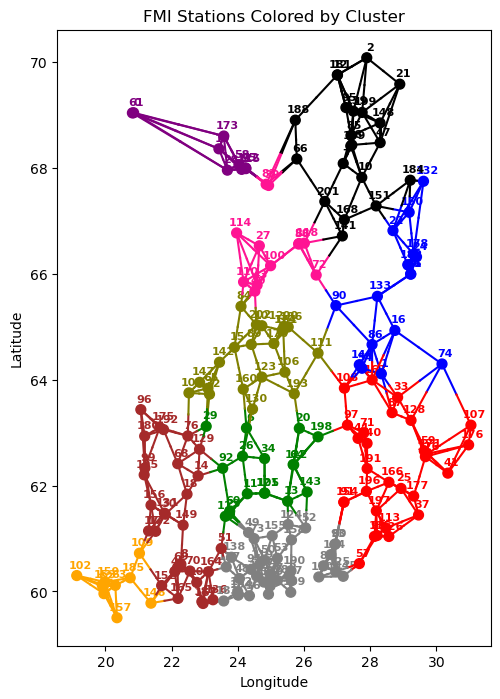

Cluster 0: [2, 7, 10, 12, 21, 38, 47, 66, 85, 95, 139, 141, 148, 151, 168, 181, 184, 188, 189, 199, 201]
Cluster 1: [6, 11, 13, 20, 23, 26, 29, 34, 60, 64, 92, 105, 117, 121, 122, 143, 198]
Cluster 2: [25, 33, 37, 41, 44, 57, 59, 71, 87, 91, 97, 98, 107, 108, 113, 116, 126, 128, 135, 140, 154, 163, 166, 171, 176, 177, 191, 196, 197]
Cluster 3: [8, 14, 17, 18, 30, 45, 51, 68, 69, 70, 76, 96, 99, 103, 129, 131, 136, 149, 152, 156, 164, 165, 167, 172, 175, 180, 187, 192, 195]
Cluster 4: [27, 39, 40, 43, 56, 72, 83, 88, 100, 110, 114, 118]
Cluster 5: [1, 4, 16, 22, 24, 31, 46, 54, 74, 86, 90, 132, 133, 144, 150, 178, 182]
Cluster 6: [15, 32, 65, 84, 89, 101, 104, 106, 111, 123, 130, 142, 147, 160, 161, 170, 174, 186, 193, 200, 202]
Cluster 7: [5, 35, 36, 42, 48, 49, 50, 52, 53, 55, 67, 73, 77, 78, 79, 80, 81, 82, 93, 94, 119, 120, 124, 125, 127, 134, 137, 138, 145, 155, 158, 162, 169, 179, 183, 190, 194]
Cluster 8: [3, 62, 63, 102, 109, 146, 153, 157, 159, 185]
Cluster 9: [0, 9, 19, 28, 58

In [12]:
### TASK ###

# Average error over all nodes in the graph
# avg_error = 

# Create a list of all coordinates
# coordinates = 

# IMPORTANT: please, set n_init='auto' for KMeans() method to pass the tests!

### BEGIN SOLUTION
# Average error over all nodes in the graph
avg_error = 0

# Create a list of all coordinates
coordinates = np.array([G_FMI.nodes[i_node]['coord'] for i_node in G_FMI.nodes])

# Fit the K-Means to the representation vector
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(coordinates)

# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

# Create the storage for average temperatures
avg_temperatures = np.zeros(k)

for cluster in range(k):
    # Define the variable to store the number of data points in the cluster
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
avg_error /= n_datapoints
### END SOLUTION
    
# Plot the clustered graph
plotFMI(G_FMI)

# Get the clusters
for cluster_i in range(k):
    cluster_nodes = [node for node in G_FMI.nodes if G_FMI.nodes[node]['cluster'] == cluster_i]
    print(f"\033[1mCluster {cluster_i}:\033[0m", cluster_nodes)

# Print the average error
print(f"\nThe average squared loss over all data points is {avg_error}")

In [13]:
# Sanity checks

# Check if the variables store numeric values
assert isinstance(avg_error, float), "The average error must be a numeric value."
assert avg_error != 0, "The average error must be equal to zero."

# Check the shape of the representation matrix
assert coordinates.shape == (203, 2), "The shape of the representation matrix is incorrect."

# Check the clustering structure
x = G_FMI.nodes[27]['cluster'] # Retrieve the cluster ID of node 27
cluster_x = [27, 39, 40, 43, 56, 72, 83, 88, 100, 110, 114, 118] # List of nodes that belong to the same cluster as node 27
assert np.all([(G_FMI.nodes[node]['cluster'] == x) == (node in cluster_x) for node in G_FMI.nodes]), "The clustering structure is incorrect."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
# Average error over all nodes in the graph
test_avg_error = 0

 # Create a list of all coordinates
coordinates = np.array([G_FMI.nodes[i_node]['coord'] for i_node in G_FMI.nodes])

# Fit the K-Means to the representation vector
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(coordinates)

# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]

# Create the storage for average temperatures
avg_temperatures = np.zeros(k)

for cluster in range(k):
    # Define the variable to store the number of data points in the cluster
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    test_avg_error += node_error
test_avg_error /= n_datapoints

# It compares the difference between actual and desired to 
# atol + rtol * abs(desired).
# Tolerance 1%: rtol=0.1 and atol=0
np.testing.assert_allclose(actual=avg_error, 
                           desired=test_avg_error, 
                           rtol=0.01, 
                           atol=0)
### END HIDDEN TESTS

Sanity check passed!


#### K-Means with GMM parameters as a representation vector

In [14]:
# Define the number components for the GMM
n_components = 2

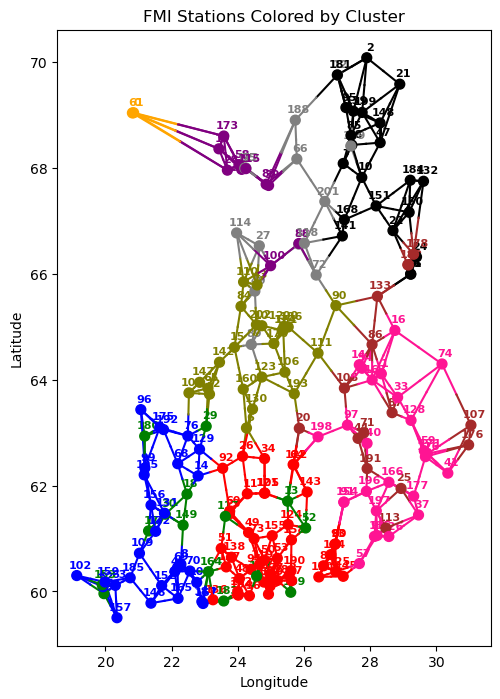

Cluster 0: [2, 7, 10, 21, 22, 24, 31, 38, 46, 47, 85, 95, 132, 139, 141, 148, 150, 151, 168, 181, 184, 199]
Cluster 1: [3, 13, 17, 18, 29, 30, 52, 117, 137, 149, 153, 164, 169, 180, 183]
Cluster 2: [5, 11, 23, 26, 34, 35, 36, 42, 48, 49, 50, 51, 53, 55, 60, 64, 67, 73, 77, 78, 79, 80, 81, 82, 92, 93, 94, 105, 119, 120, 121, 122, 124, 125, 127, 134, 136, 138, 143, 145, 155, 158, 162, 179, 190, 194]
Cluster 3: [4, 20, 25, 44, 71, 86, 87, 107, 108, 113, 133, 176, 178, 182, 191]
Cluster 4: [1, 16, 33, 37, 41, 54, 57, 59, 74, 91, 97, 98, 116, 126, 128, 135, 140, 144, 154, 163, 166, 171, 177, 196, 197, 198]
Cluster 5: [8, 14, 45, 62, 63, 68, 69, 70, 76, 96, 99, 102, 103, 109, 129, 131, 146, 152, 156, 157, 159, 165, 167, 172, 175, 185, 187, 192, 195]
Cluster 6: [6, 15, 32, 43, 65, 84, 90, 101, 104, 106, 110, 111, 123, 130, 142, 147, 160, 161, 170, 174, 186, 193, 200, 202]
Cluster 7: [12, 27, 40, 56, 66, 72, 75, 89, 112, 114, 118, 188, 189, 201]
Cluster 8: [0, 61]
Cluster 9: [9, 19, 28, 39, 58

In [15]:
### TASK ###

# Average error over all nodes in the graph
# avg_error = 

# Get the GMM parameters of all the nodes in the graph
# gmm_params = 

### BEGIN SOLUTION
# Average error over all nodes in the graph
avg_error = 0

# Fit the nodes to the GMM model and extract the model's parameters
for node in G_FMI.nodes():
    
    # Extract node's features
    node_X = G_FMI.nodes[node]['X']
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state = seed) 
    gmm.fit(node_X)
    
    # Get the parameters of the GMM (mean vectors, covariance matricies, and component weights)
    gmm_params = np.concatenate((np.concatenate((gmm.means_.ravel(), gmm.covariances_.ravel())), gmm.weights_))
    
    # Assign GMM parameters to the node
    G_FMI.nodes[node]['gmm_params'] = gmm_params

# Get the GMM parameters of all the nodes in the graph
gmm_params = np.array([G_FMI.nodes[i_node]['gmm_params'] for i_node in G_FMI.nodes])

# Fit the K-Means to the representation vector
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(gmm_params)

# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
# Create the storage for average temperatures
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
avg_error /= n_datapoints

### END SOLUTION
    
# Plot the clustered graph
plotFMI(G_FMI)

# Get the clusters
for cluster_i in range(k):
    cluster_nodes = [node for node in G_FMI.nodes if G_FMI.nodes[node]['cluster'] == cluster_i]
    print(f"\033[1mCluster {cluster_i}:\033[0m", cluster_nodes)

# Print the average error
print(f"\nThe average squared loss over all datapoints is {avg_error}")

In [16]:
# Sanity checks

# Check if the variables store numeric values
assert isinstance(avg_error, float), "The average error must be a numeric value."
assert avg_error != 0, "The average error must be equal to zero."

# Check the final representation matrix
assert gmm_params.shape == (203, 114), "The shape of representation matrix is incorrect."

# Check the clustering structure
x = G_FMI.nodes[0]['cluster'] # Retrieve the cluster ID of node 0
cluster_x = [0, 61] # List of nodes that belong to the same cluster as node 0
assert np.all([(G_FMI.nodes[node]['cluster'] == x) == (node in cluster_x) for node in G_FMI.nodes]), "The clustering structure is incorrect."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
# Average error over all nodes in the graph
test_avg_error = 0

# Fit the nodes to the GMM model and extract the model's parameters
for node in G_FMI.nodes():
    
    # Extract node's features
    node_X = G_FMI.nodes[node]['X']
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state = seed) 
    gmm.fit(node_X)
    
    # Get the parameters of the GMM (mean vectors, covariance matricies, and component weights)
    gmm_params = np.concatenate((np.concatenate((gmm.means_.ravel(), gmm.covariances_.ravel())), gmm.weights_))
    
    # Assign GMM parameters to the node
    G_FMI.nodes[node]['gmm_params'] = gmm_params

# Get the GMM parameters of all the nodes in the graph
gmm_params = np.array([G_FMI.nodes[i_node]['gmm_params'] for i_node in G_FMI.nodes])

# Fit the K-Means to the representation vector
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(gmm_params)

# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
# Create the storage for average temperatures
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    test_avg_error += node_error
test_avg_error /= n_datapoints

# It compares the difference between actual and desired to 
# atol + rtol * abs(desired).
# Tolerance 1%: rtol=0.1 and atol=0
np.testing.assert_allclose(actual=avg_error, 
                           desired=test_avg_error, 
                           rtol=0.01, 
                           atol=0)
### END HIDDEN TESTS

Sanity check passed!


#### K-Means with eigenvectors of the Laplacian matrix as a representation vector

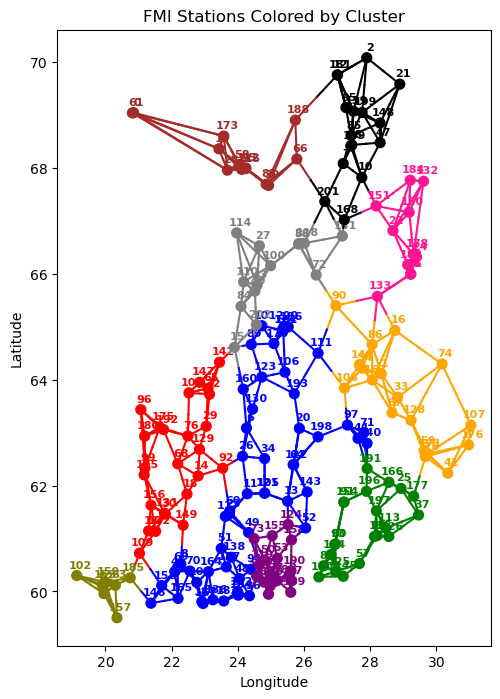

Cluster 0: [2, 7, 10, 12, 21, 38, 47, 85, 95, 139, 148, 168, 181, 189, 199, 201]
Cluster 1: [25, 37, 57, 80, 81, 91, 93, 98, 113, 120, 125, 126, 135, 145, 154, 166, 177, 191, 194, 196, 197]
Cluster 2: [14, 17, 18, 29, 30, 32, 65, 68, 76, 92, 96, 99, 104, 109, 129, 131, 142, 147, 149, 156, 172, 175, 180, 192, 195]
Cluster 3: [0, 9, 19, 28, 39, 58, 61, 66, 75, 83, 112, 115, 173, 188]
Cluster 4: [4, 22, 24, 31, 46, 132, 133, 150, 151, 178, 182, 184]
Cluster 5: [6, 8, 11, 13, 20, 23, 26, 34, 36, 44, 45, 48, 49, 51, 52, 60, 64, 69, 70, 71, 89, 94, 97, 101, 103, 105, 106, 111, 117, 121, 122, 123, 127, 130, 134, 136, 138, 140, 143, 146, 152, 160, 161, 162, 164, 165, 167, 170, 174, 183, 186, 187, 193, 198, 200]
Cluster 6: [3, 62, 63, 102, 153, 157, 159, 185]
Cluster 7: [15, 27, 40, 43, 56, 72, 84, 88, 100, 110, 114, 118, 141, 202]
Cluster 8: [1, 16, 33, 41, 54, 59, 74, 86, 87, 90, 107, 108, 116, 128, 144, 163, 171, 176]
Cluster 9: [5, 35, 42, 50, 53, 55, 67, 73, 77, 78, 79, 82, 119, 124, 137, 

In [17]:
### TASK ###

# Average error over all nodes in the graph
# avg_error = 

# The k smallest eigenvectors to use for clustering
# k_eigen = 

### BEGIN SOLUTION
# Average error over all nodes in the graph
avg_error = 0

# Construct the Laplacian matrix
L = nx.laplacian_matrix(G_FMI).toarray()

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = LA.eig(L)

idx_sorted = np.argsort(eigenvalues)

eigenvalues_sorted = eigenvalues[idx_sorted]

eigenvectors_sorted = eigenvectors.T[idx_sorted]

# The k smallest eigenvectors to use for clustering
k_eigen = eigenvectors_sorted[1:k+1].T

# Fit the K-Means to the representation vector
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(k_eigen)


# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
# Create the storage for average temperatures
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    avg_error += node_error
avg_error /= n_datapoints
### END SOLUTION
    
# Plot the clustered graph
plotFMI(G_FMI, save_path='clustered_FMI_graph.png')

# Get the clusters
for cluster_i in range(k):
    cluster_nodes = [node for node in G_FMI.nodes if G_FMI.nodes[node]['cluster'] == cluster_i]
    print(f"\033[1mCluster {cluster_i}:\033[0m", cluster_nodes)

# Print the average error
print(f"\nThe average squared loss over all datapoints is {avg_error}")

In [19]:
# Sanity checks

# Check if the variables store numeric values
assert isinstance(avg_error, float), "The average error must be a numeric value."
assert avg_error != 0, "The average error must be equal to zero."

# Check the final representation matrix
assert k_eigen.shape == (203, 10), "The shape of representation matrix is incorrect."

# Check the clustering structure
x = G_FMI.nodes[0]['cluster'] # Retrieve the cluster ID of node 0
cluster_x = [0, 9, 19, 28, 39, 58, 61, 66, 75, 83, 112, 115, 173, 188] # List of nodes that belong to the same cluster as node 0
assert np.all([(G_FMI.nodes[node]['cluster'] == x) == (node in cluster_x) for node in G_FMI.nodes]), "The clustering structure is incorrect."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
# Average error over all nodes in the graph
test_avg_error = 0
test_avg_error_without_first = 0

# Construct the Laplacian matrix
L = nx.laplacian_matrix(G_FMI).toarray()

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = LA.eig(L)

idx_sorted = np.argsort(eigenvalues)

eigenvalues_sorted = eigenvalues[idx_sorted]
eigenvectors_sorted = eigenvectors.T[idx_sorted]

k_eigen = eigenvectors_sorted[1:k+1].T

# Fit the K-Means to the representation vector
kmeans = KMeans(n_clusters = k, random_state = seed, n_init = 'auto')
kmeans.fit(k_eigen)

# Assign cluster labels to the nodes in the graph
for i, node in enumerate(G_FMI.nodes):
    G_FMI.nodes[node]['cluster'] = kmeans.labels_[i]
    
# Create the storage for average temperatures
avg_temperatures = np.zeros(k)
for cluster in range(k):
    # Define the variable to store the number of data points in the cluster
    cluster_cnt = 0
    for node in G_FMI.nodes:
        if G_FMI.nodes[node]['cluster'] == cluster:
            avg_temperatures[cluster] += np.sum(G_FMI.nodes[node]['y'])
            cluster_cnt += G_FMI.nodes[node]['samplesize']
    avg_temperatures[cluster] /= cluster_cnt

for node in G_FMI.nodes:
    cluster_avg_temp = avg_temperatures[G_FMI.nodes[node]['cluster']]
    node_error = np.sum((G_FMI.nodes[node]['y'] - cluster_avg_temp) ** 2) 
    test_avg_error += node_error
test_avg_error /= n_datapoints

# Ensure avg_error is close to test_avg_error
np.testing.assert_allclose(actual=avg_error, 
                           desired=test_avg_error, 
                           rtol=0.01, 
                           atol=0)
### END HIDDEN TESTS

Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

### Question 5.1 - Single-Model FL

__Formulation:__

For which scenarios is clustered FL preferable over single-model FL?
    
__Answer Options:__
    
1. The local datasets are heterogeneous in the sense of having different statistical properties. 
2. The local datasets have similar statistical properties, but some of them are too small.
3. The local datasets have similar statistical properties, but some of them are too large.
4. The local datasets have similar statistical properties, but some local datasets use different features for datapoints.

</div>

In [20]:
### Question ###

# Assign the variable to the answer option from the list above
# answer =

### BEGIN SOLUTION
answer = 1
### END SOLUTION

In [21]:
# Sanity checks

# Check if the chosen answer option is adequate
assert answer in [1, 2, 3, 4], "Choose the answer option from the provided list."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
test_answer = 1
np.testing.assert_equal(actual = answer,
                        desired = test_answer)
### END HIDDEN TESTS

Sanity check passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">

### Question 5.2 - Horizontal FL

__Formulation:__

Which of the following statements characterize horizontal FL?    
    
__Answer Options:__
    
1. The data points must be characterized by the same features in all local datasets.
2. Horizontal FL can be considered a form of semi-supervised learning.
3. All local datasets must contain identical data points.
4. The features used in a local dataset must be a proper subset of the raw features measured for each data point.
    
</div>

In [22]:
### Question ###

# Assign the variable to the set containing correct answers
# answer =

### BEGIN SOLUTION
answer = {1, 2}
### END SOLUTION

In [23]:
# Sanity checks

# Check if the variable is a set
assert isinstance(answer, set), "The answer is not a set."

# Check if the chosen answer option is adequate
assert answer.issubset({1, 2, 3, 4}), "Choose the answer options from the provided list."

print('Sanity check passed!')

### BEGIN HIDDEN TESTS
test_answer = {1, 2}
np.testing.assert_equal(actual = answer,
                        desired = test_answer)
### END HIDDEN TESTS

Sanity check passed!
